# Results Evaluation and Visualization

In this notebook, the results are evaluated in several steps:
1. Finding the best parameter configurations per LLM
2. Comparing the performance of all tested LLMs
3. Visualization + Significance Tests for Annotation Attribute Value Group Differences
4. Overall Significance Test Results Overview

The master's thesis contains a detailed review and discussion of the shown results.

In [2]:
%run ../scripts/data_visualizations.py
%run ../scripts/df_calculations.py
%run ../scripts/significance_tests.py

In [3]:
import json
import time

In [4]:
n_permutations = 1000

## LLM Comparison

In [5]:
with open('../data/all_results.json', 'r') as f:
    all_results = json.load(f)

### Best Configuration Parameters per Model

In [6]:
def get_best_model_configurations(all_results):
    best_configs = {}
    
    for model_name, configurations in all_results.items():
        best_config = None
        best_balanced_accuracy = -1
        best_config_name = None
        
        for config_name, config_data in configurations.items():
            # Only consider 'all' results
            if 'all' in config_data:
                balanced_accuracy = config_data['all'].get('Balanced Accuracy', -1)
                if balanced_accuracy > best_balanced_accuracy:
                    best_balanced_accuracy = balanced_accuracy
                    best_config = config_data['all']
                    best_config_name = config_name
        
        if best_config is not None:
            best_configs[model_name] = {
                'configuration': best_config_name,
                'balanced_accuracy': best_balanced_accuracy,
                'results': best_config
            }
    
    return best_configs

In [7]:
best_model_configs = get_best_model_configurations(all_results)

print("Best model configurations based on highest Balanced Accuracy:\n")
for model, data in best_model_configs.items():
    print(f"{model}: {data['configuration']} (Balanced Accuracy: {data['balanced_accuracy']:.3f})")

Best model configurations based on highest Balanced Accuracy:

gpt-3.5-turbo-0125: only_text_256_20 (Balanced Accuracy: 0.764)
gpt-4.1-nano-2025-04-14: 256_20 (Balanced Accuracy: 0.774)
gpt-4.1-mini-2025-04-14: only_text_1024_20 (Balanced Accuracy: 0.833)
gpt-4.1-2025-04-14: only_text_1024_20 (Balanced Accuracy: 0.856)
llama3.1.70b: only_text_1024_20 (Balanced Accuracy: 0.819)
llama4.scout: only_text_256_20 (Balanced Accuracy: 0.791)


## Performance Comparison between all LLMs

Displaying Balanced Accuracy and Unsubstantiated F1-Score for each model.

In [8]:
model_names = {
 'gpt-3.5-turbo-0125': 'GPT-3.5 Turbo',
 'gpt-4.1-nano-2025-04-14': 'GPT-4.1 nano',
 'gpt-4.1-mini-2025-04-14': 'GPT-4.1 mini',
 'gpt-4.1-2025-04-14': 'GPT-4.1',
 'llama3.1.70b': 'Llama 3.1 70B',
 'llama4.scout': 'Llama 4 Scout'
 }

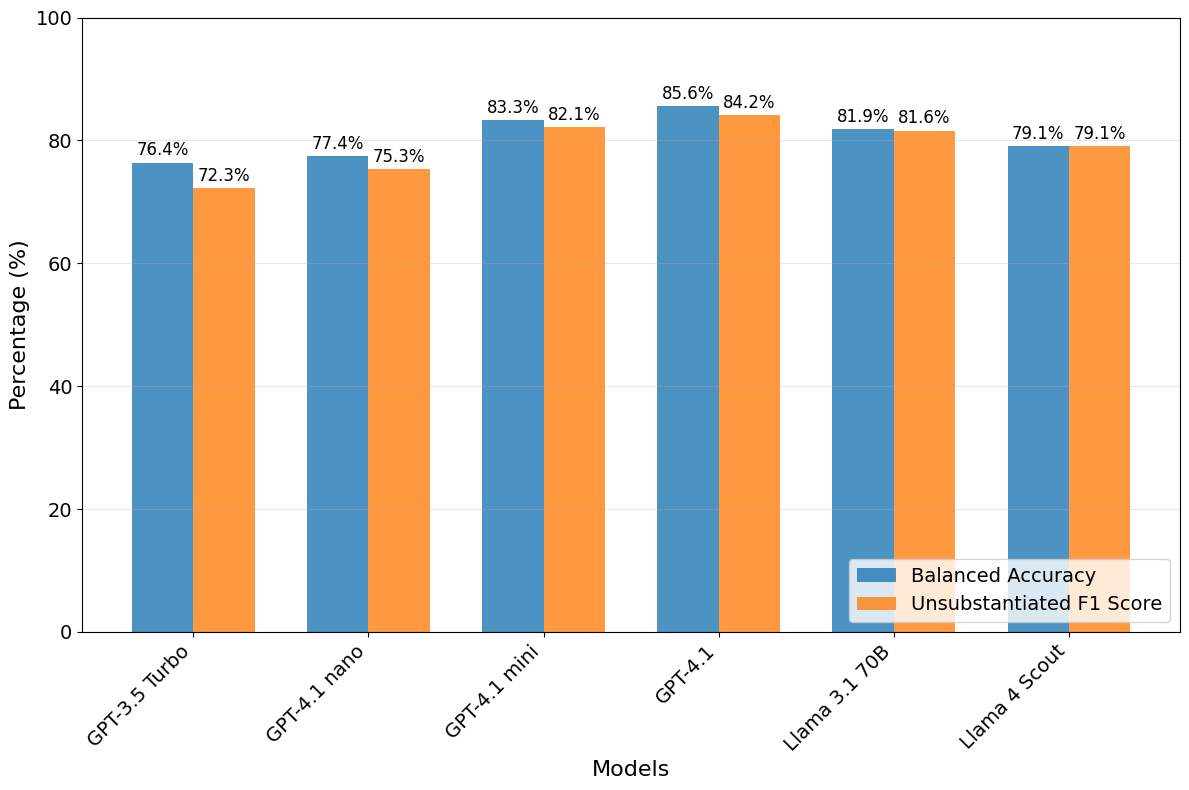

In [9]:
show_best_models_comparison(best_model_configs, model_names=model_names, title='', save_title="best_models_results")

### Detailed Metrics Comparison between Best Model Configurations

In [10]:
results_gpt_3_5_turbo = all_results["gpt-3.5-turbo-0125"]["only_text_256_20"]["all"]
results_gpt_4_1_nano = all_results["gpt-4.1-nano-2025-04-14"]["256_20"]["all"]
results_gpt_4_1_mini = all_results["gpt-4.1-mini-2025-04-14"]["only_text_1024_20"]["all"]
results_gpt_4_1 = all_results["gpt-4.1-2025-04-14"]["only_text_1024_20"]["all"]
results_llama_3_1 = all_results["llama3.1.70b"]["only_text_256_20"]["all"]
results_llama_4_scout = all_results["llama4.scout"]["only_text_256_20"]["all"]

In [11]:
best_model_results = {
    "GPT-3.5 Turbo\n(256 Token Chunks, with PBTE)": results_gpt_3_5_turbo,
    "GPT-4.1 nano\n(256 Token Chunks, no PBTE)": results_gpt_4_1_nano,
    "GPT-4.1 mini\n(1024 Token Chunks, with PBTE)": results_gpt_4_1_mini,
    "GPT-4.1\n(1024 Token Chunks, with PBTE)": results_gpt_4_1,
    "Llama 3.1 70B\n(256 Token Chunks, with PBTE)": results_llama_3_1,
    "Llama 4 Scout\n(256 Token Chunks, with PBTE)": results_llama_4_scout,
}

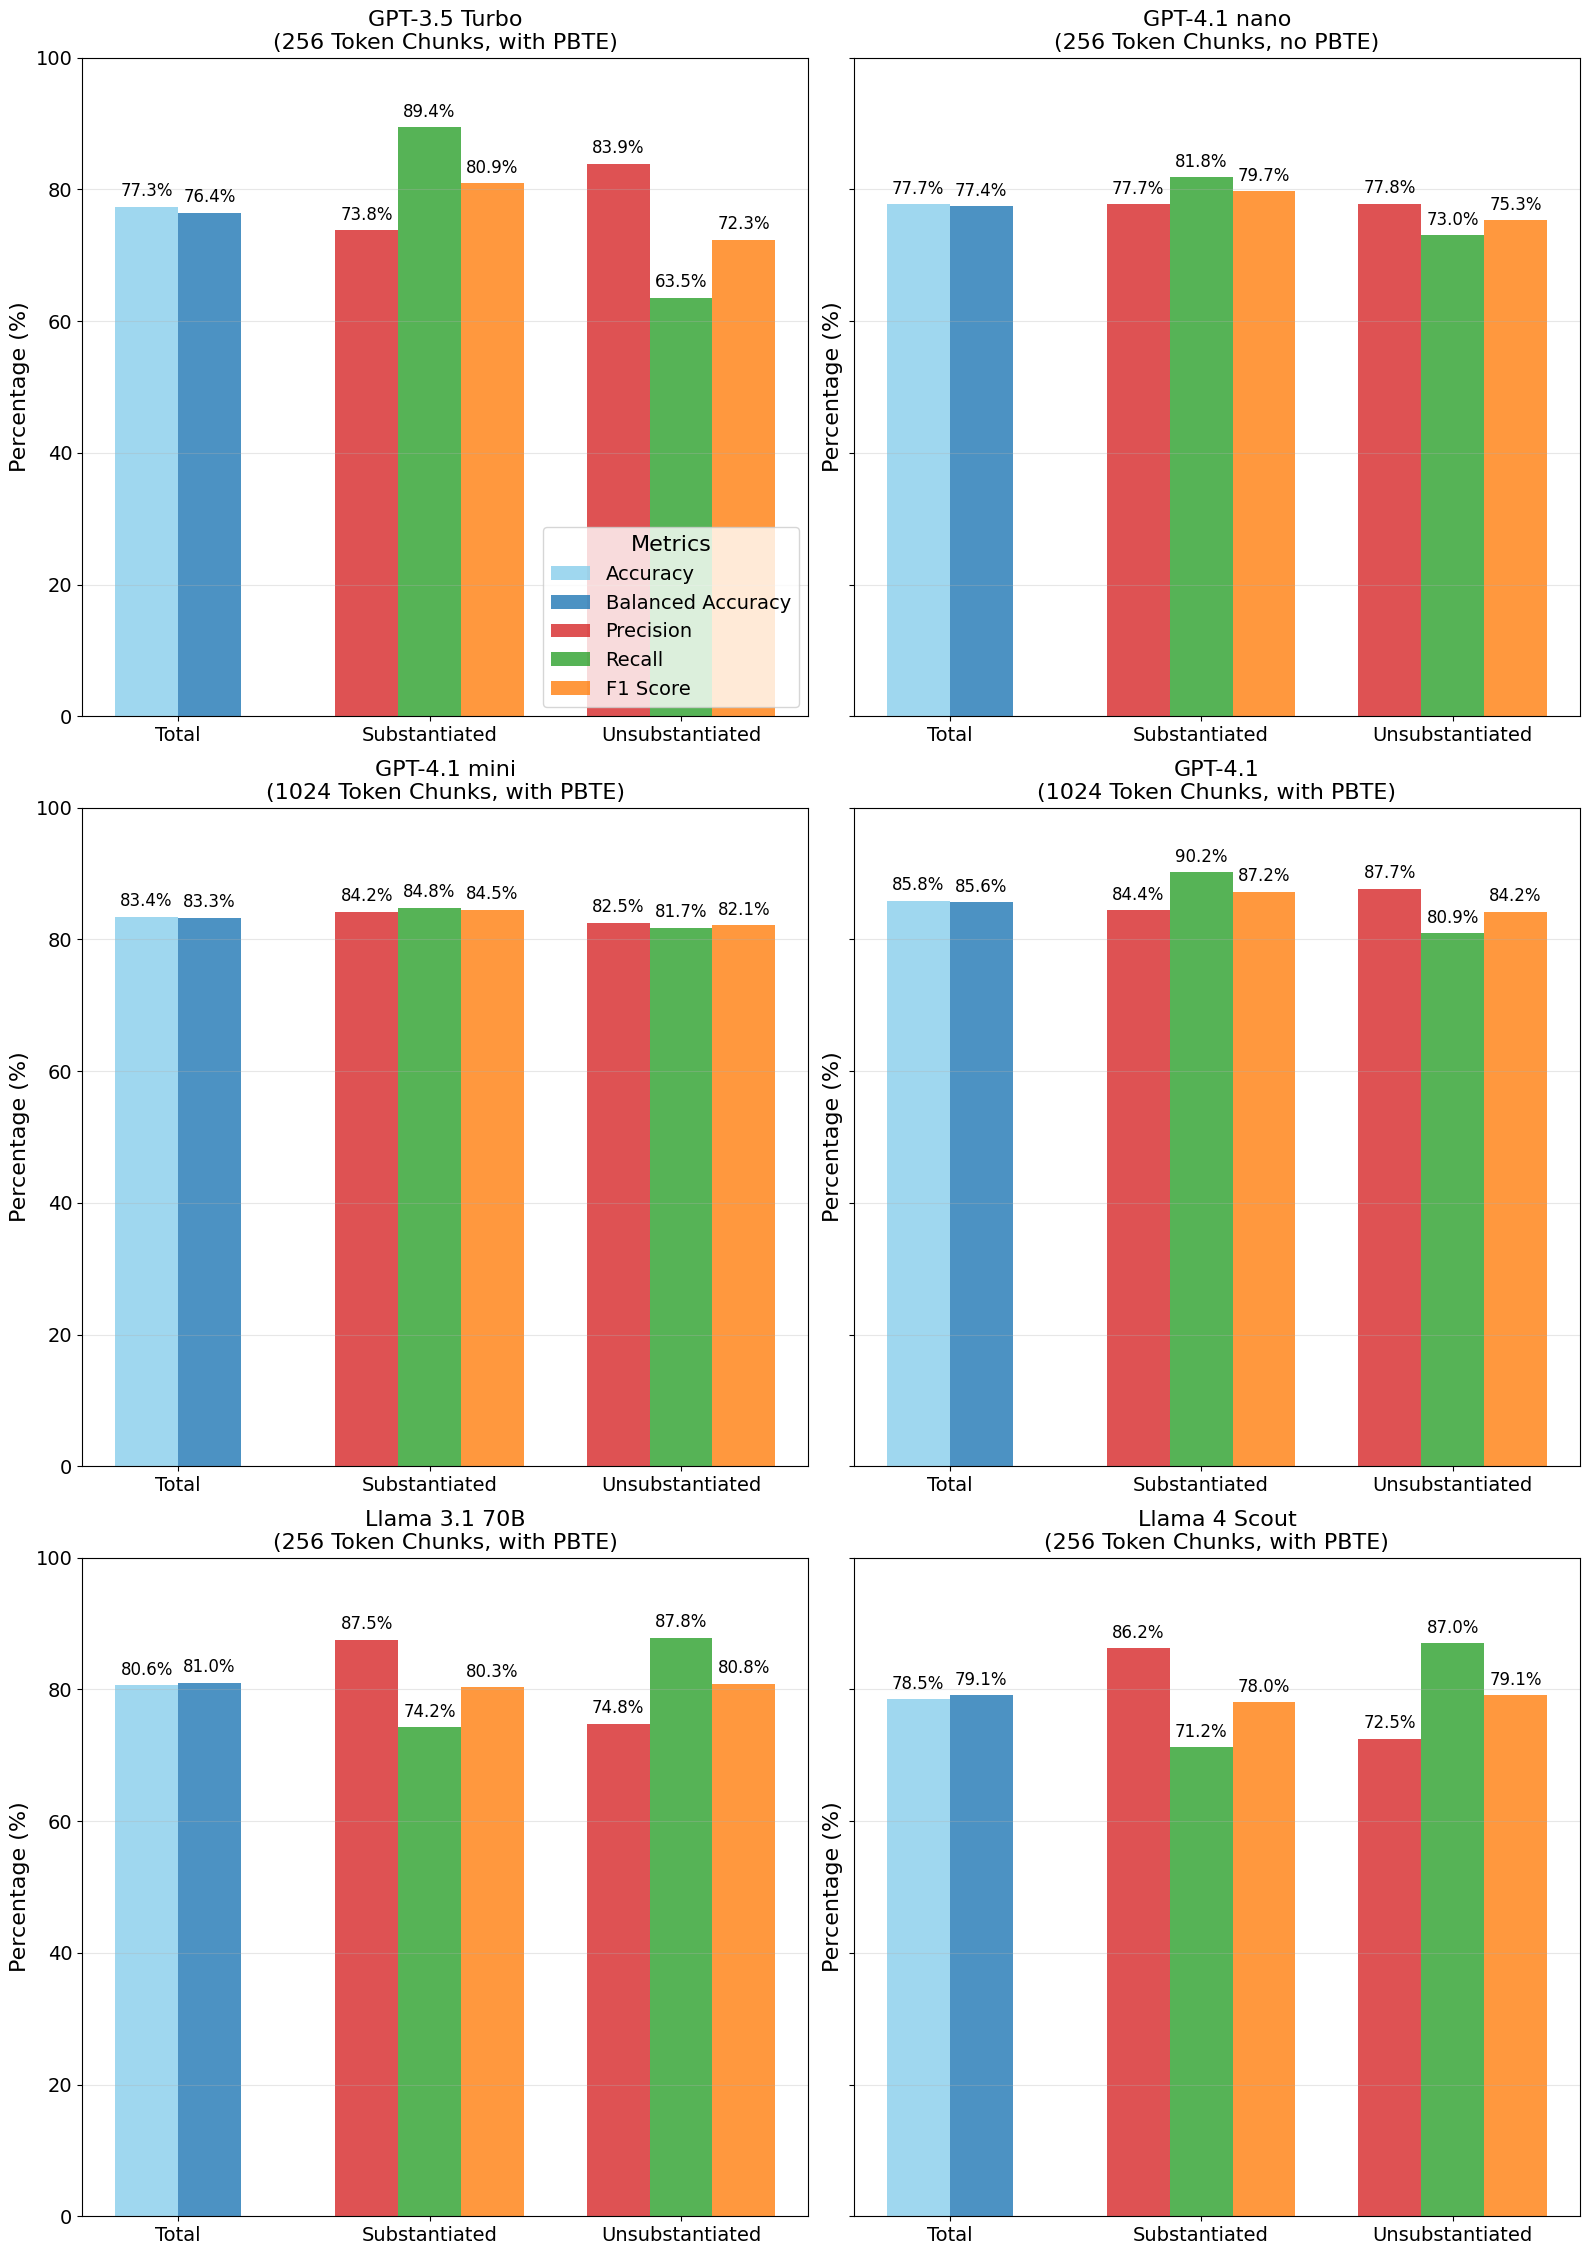

In [12]:
show_metrics_per_label(best_model_results, "", save_title="detailed_metrics_other_llama_gpt_models")

## Evaluation per Annotation Attribute

### Helper Functions for Significance Testing

In [13]:
def attribute_predictions_per_model(model_dfs, attribute, relabelled_partially=False, group_numbers_from=False):
    results = {}
    for model_name, df in model_dfs.items():
        results[model_name] = eval_predictions_per_attribute_value(df, attribute, include_relabelled_partially=True, group_numbers_from=group_numbers_from)
        if relabelled_partially:
            results[model_name + " (exclude relabelled partially)"] = eval_predictions_per_attribute_value(df, attribute, include_relabelled_partially=False, group_numbers_from=group_numbers_from)
    return results

In [14]:
def fisher_exact_overall_for_attribute(df, attribute, group_numbers_from=False):
    attribute_groups = get_attribute_value_groups(df, attribute, group_numbers_from)
    evals = eval_per_attribute_value(df, attribute, attribute_groups)
    results = calc_fisher_exact_overall_total_sub_unsub(evals, [group_name for group_name, _ in attribute_groups])
    display_fisher_exact_overall_test_results(results)
    return results

In [15]:
def permutation_test_for_attribute(df, attribute, group_numbers_from, n_permutations):
    results = calc_permutation_test_total_sub_unsub(df, attribute, group_numbers_from, n_permutations)
    display_permutation_test_results(results)
    return results

In [16]:
def significance_tests_for_attribute(df, model_name, attribute, group_numbers_from=False):
    global n_permutations
    
    results = {}
    print(f"---- ## Significance tests results for {model_name} on attribute '{attribute}': ## ----")

    # Fishers exact test (overall comparison)
    print(f"Fisher's exact test results (comparison over all attribute values):")
    current_time = time.time()
    fisher_exact_overall_results = fisher_exact_overall_for_attribute(df, attribute, group_numbers_from)
    results['Fisher Exact Overall'] = fisher_exact_overall_results
    print(f"Time taken for overall Fisher's exact test: {time.time() - current_time:.2f} seconds\n")

    # Permutation test (overall comparison)
    print(f"Permutation test results (comparison per metric over {n_permutations} permutations):")
    current_time = time.time()
    permutation_test_results = permutation_test_for_attribute(df, attribute, group_numbers_from, n_permutations)
    results['Permutation Test'] = permutation_test_results
    print(f"Time taken for permutation test: {time.time() - current_time:.2f} seconds\n")

    print("\n\n")
    return results

### Loading Best Configuration (LLM: GPT 4.1)

In [17]:
chunking = "1024_20"
only_text = True
model = "gpt-4.1-2025-04-14"
df_gpt = load_df_for_analysis(chunking, only_text, model)

model_dfs = {  
    "GPT-4.1": df_gpt
}

analyzed_df = df_gpt
analyzed_model = "GPT-4.1"
significance_tests_results = {}
results_per_attribute = {}

### Reference Only

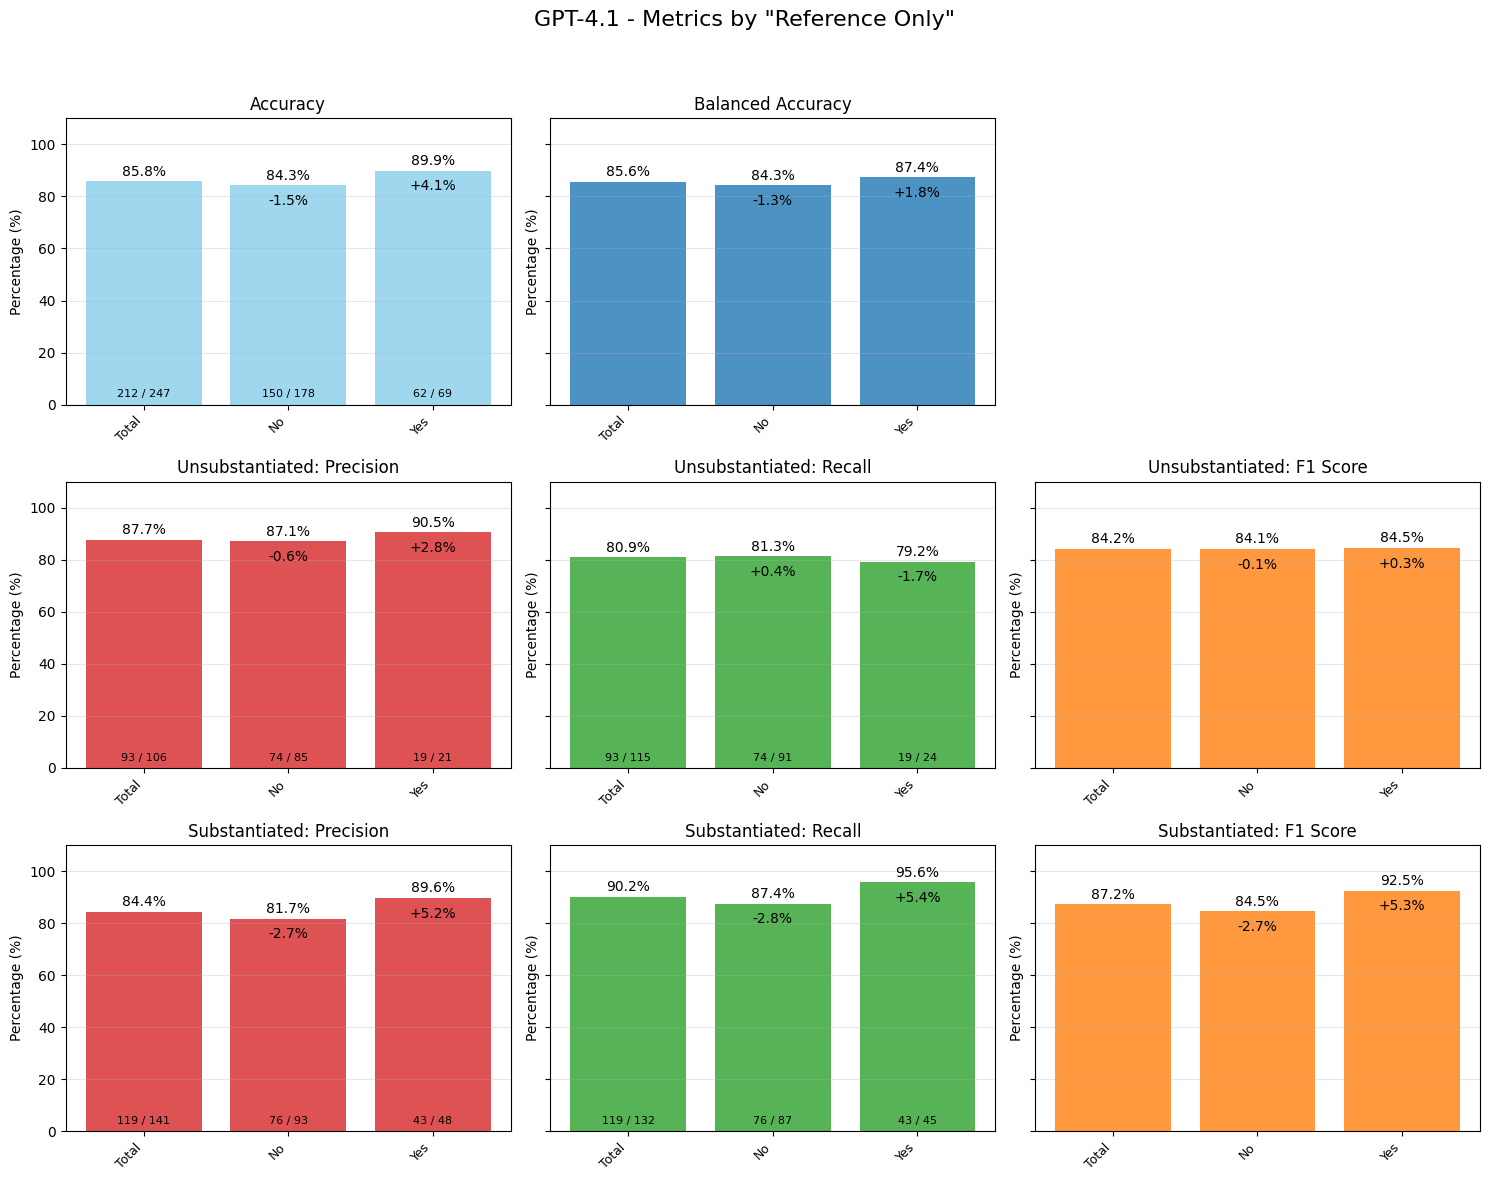

In [18]:
attribute = "Reference Only"
results = attribute_predictions_per_model(model_dfs, attribute)
results_per_attribute[attribute] = results[analyzed_model]
show_metrics_by_attribute_values(results, attribute, analyzed_model)

In [19]:
significance_tests_results[attribute] = significance_tests_for_attribute(analyzed_df, analyzed_model, attribute)

---- ## Significance tests results for GPT-4.1 on attribute 'Reference Only': ## ----
Fisher's exact test results (comparison over all attribute values):


,Total Odds Ratio,Total P-value,Unsubstantiated Odds Ratio,Unsubstantiated P-value,Substantiated Odds Ratio,Substantiated P-value
0,1.6533,0.3129,0.8730,0.7769,3.1118,0.2172


Time taken for overall Fisher's exact test: 0.16 seconds

Permutation test results (comparison per metric over 1000 permutations):


,Total Var Diff,Total P-value,Unsubstantiated Var Diff,Unsubstantiated P-value,Substantiated Var Diff,Substantiated P-value
Metric,,,,,,
Balanced Accuracy,-0.000500,0.5390,N/A,N/A,N/A,N/A
Accuracy,0.000200,0.3110,N/A,N/A,N/A,N/A
Precision,N/A,N/A,-0.000900,0.6430,0.000300,0.2540
Recall,N/A,N/A,-0.001600,0.8380,0.000800,0.1670
F1 Score,N/A,N/A,-0.000900,0.9540,0.001000,0.1030


Time taken for permutation test: 10.07 seconds






### Claim Contains Number or Formula

In [20]:
get_attribute_value_groups(model_dfs["GPT-4.1"], "Claim Contains Number or Formula", group_numbers_from="Number/Formula")

[('No', ['No']), ('Number/\nFormula', ['Number', 'Formula'])]

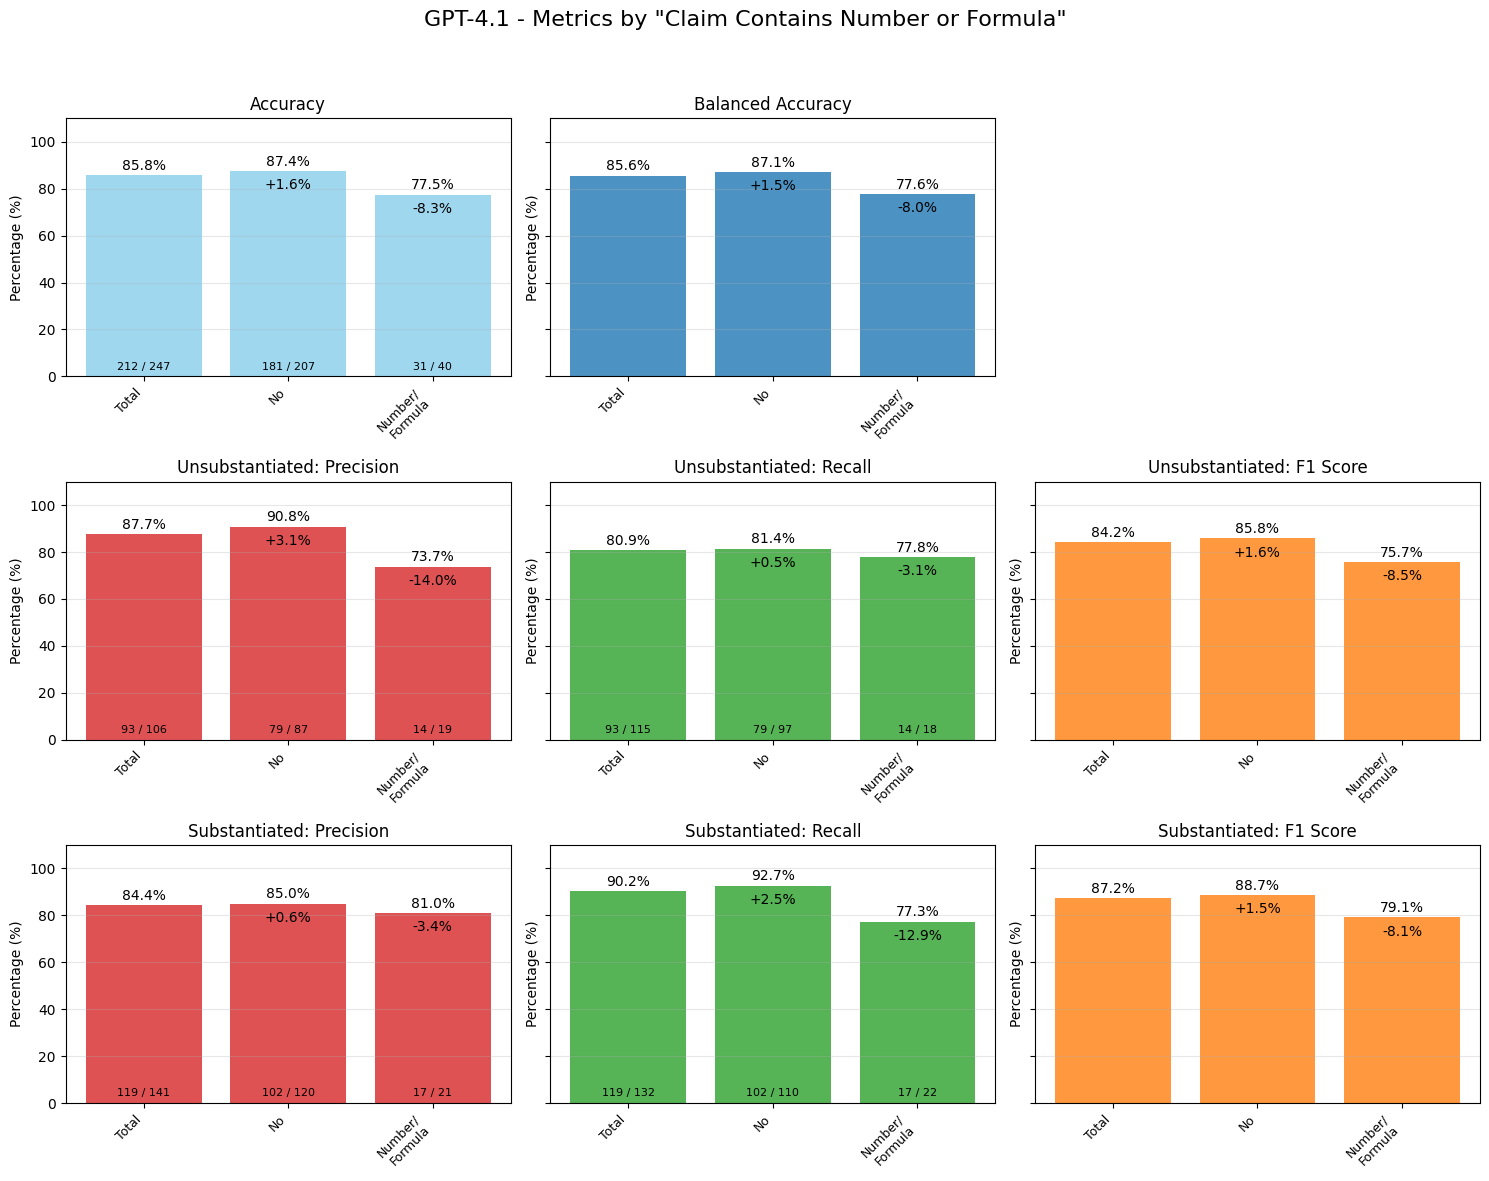

In [21]:
attribute = "Claim Contains Number or Formula"
results = attribute_predictions_per_model(model_dfs, attribute, group_numbers_from="Number/Formula")
results_per_attribute[attribute] = results[analyzed_model]
show_metrics_by_attribute_values(results, attribute, analyzed_model)

In [22]:
significance_tests_results[attribute] = significance_tests_for_attribute(analyzed_df, analyzed_model,attribute)

---- ## Significance tests results for GPT-4.1 on attribute 'Claim Contains Number or Formula': ## ----
Fisher's exact test results (comparison over all attribute values):


,Total Statistic,Total P-value,Unsubstantiated Statistic,Unsubstantiated P-value,Substantiated Statistic,Substantiated P-value
0,0.0201,0.1520,0.0747,0.5601,0.0123,0.0321


Time taken for overall Fisher's exact test: 0.04 seconds

Permutation test results (comparison per metric over 1000 permutations):


,Total Var Diff,Total P-value,Unsubstantiated Var Diff,Unsubstantiated P-value,Substantiated Var Diff,Substantiated P-value
Metric,,,,,,
Balanced Accuracy,-0.004800,0.6510,N/A,N/A,N/A,N/A
Accuracy,-0.003500,0.6540,N/A,N/A,N/A,N/A
Precision,N/A,N/A,-0.014000,0.4070,-0.004300,0.3800
Recall,N/A,N/A,-0.007800,0.3200,0.022800,0.0630
F1 Score,N/A,N/A,-0.011800,0.4990,0.000400,0.1850


Time taken for permutation test: 10.65 seconds






### Amount of Citations in Sentence

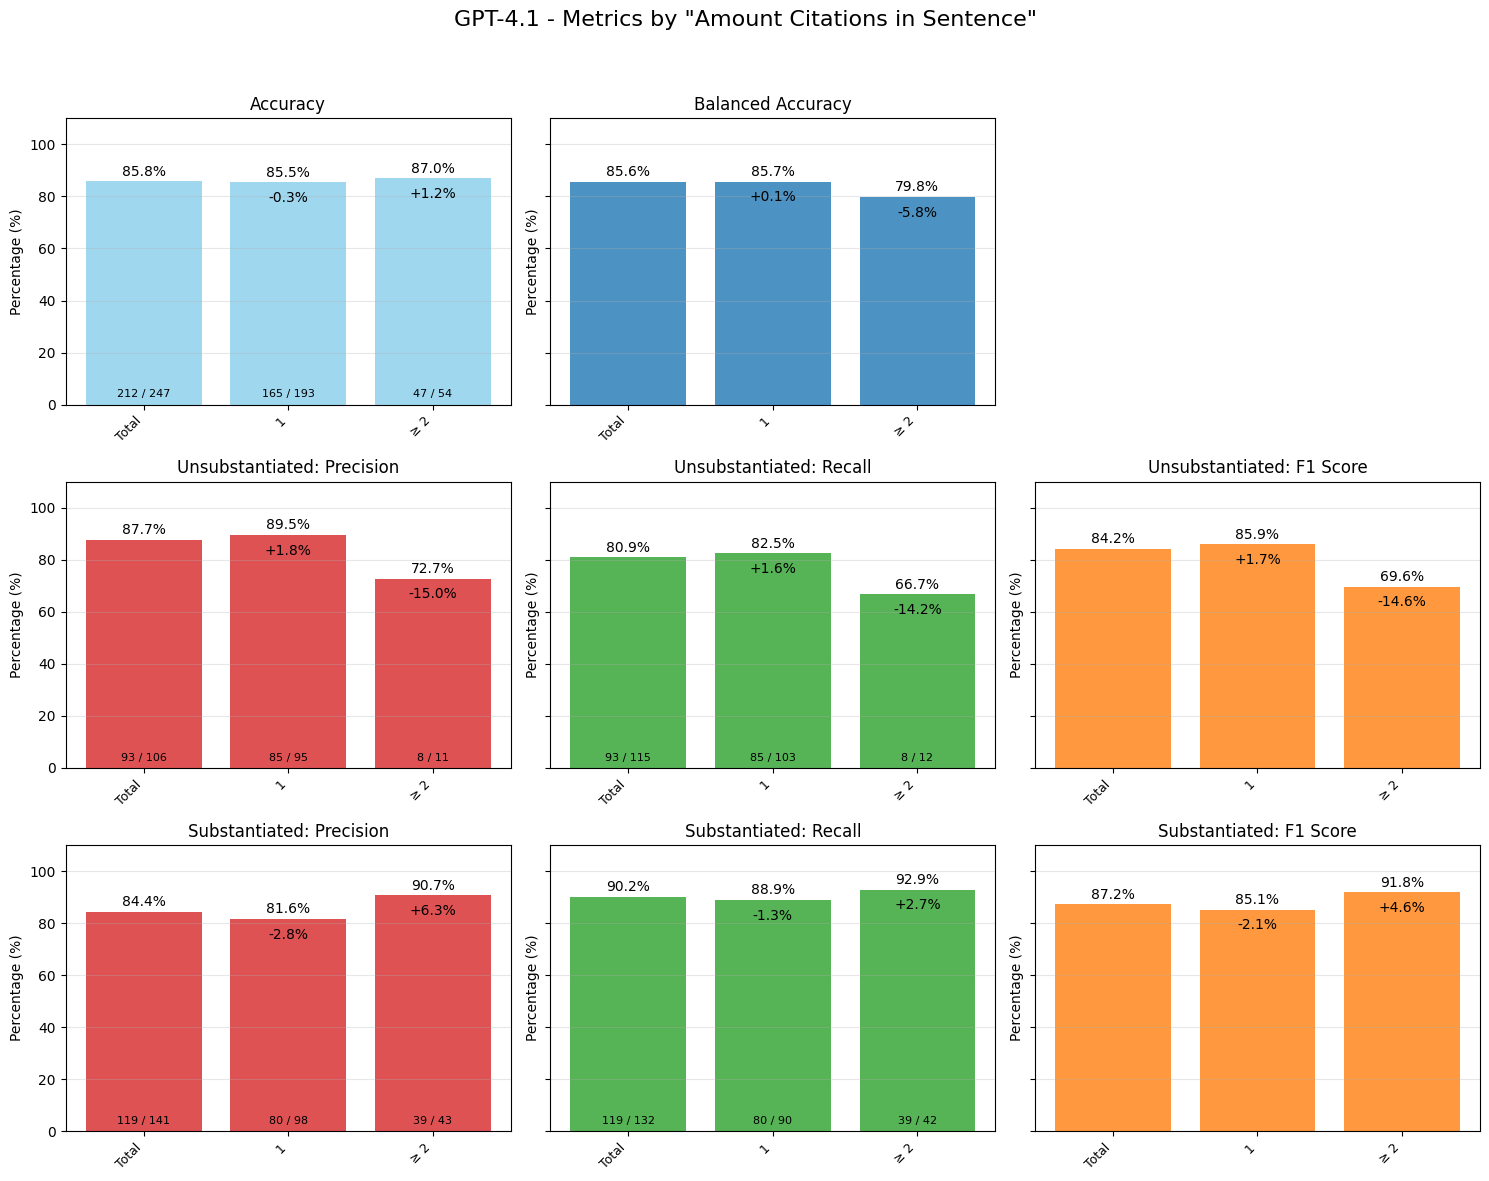

In [23]:
attribute = "Amount Citations in Sentence"
results = attribute_predictions_per_model(model_dfs, attribute, group_numbers_from=2)
results_per_attribute[attribute] = results[analyzed_model]
show_metrics_by_attribute_values(results, attribute, analyzed_model)

In [24]:
significance_tests_results[attribute] = significance_tests_for_attribute(analyzed_df, analyzed_model, attribute, group_numbers_from=2)

---- ## Significance tests results for GPT-4.1 on attribute 'Amount Citations in Sentence': ## ----
Fisher's exact test results (comparison over all attribute values):


,Total Odds Ratio,Total P-value,Unsubstantiated Odds Ratio,Unsubstantiated P-value,Substantiated Odds Ratio,Substantiated P-value
0,0.8777,1.0000,2.3611,0.2396,0.6154,0.5499


Time taken for overall Fisher's exact test: 0.02 seconds

Permutation test results (comparison per metric over 1000 permutations):


,Total Var Diff,Total P-value,Unsubstantiated Var Diff,Unsubstantiated P-value,Substantiated Var Diff,Substantiated P-value
Metric,,,,,,
Balanced Accuracy,0.000200,0.2660,N/A,N/A,N/A,N/A
Accuracy,-0.000600,0.8020,N/A,N/A,N/A,N/A
Precision,N/A,N/A,0.005500,0.0220,0.000900,0.1910
Recall,N/A,N/A,0.004300,0.0620,-0.000700,0.5690
F1 Score,N/A,N/A,0.005600,0.0120,0.000400,0.1950


Time taken for permutation test: 10.16 seconds






### Amount of References for Claim

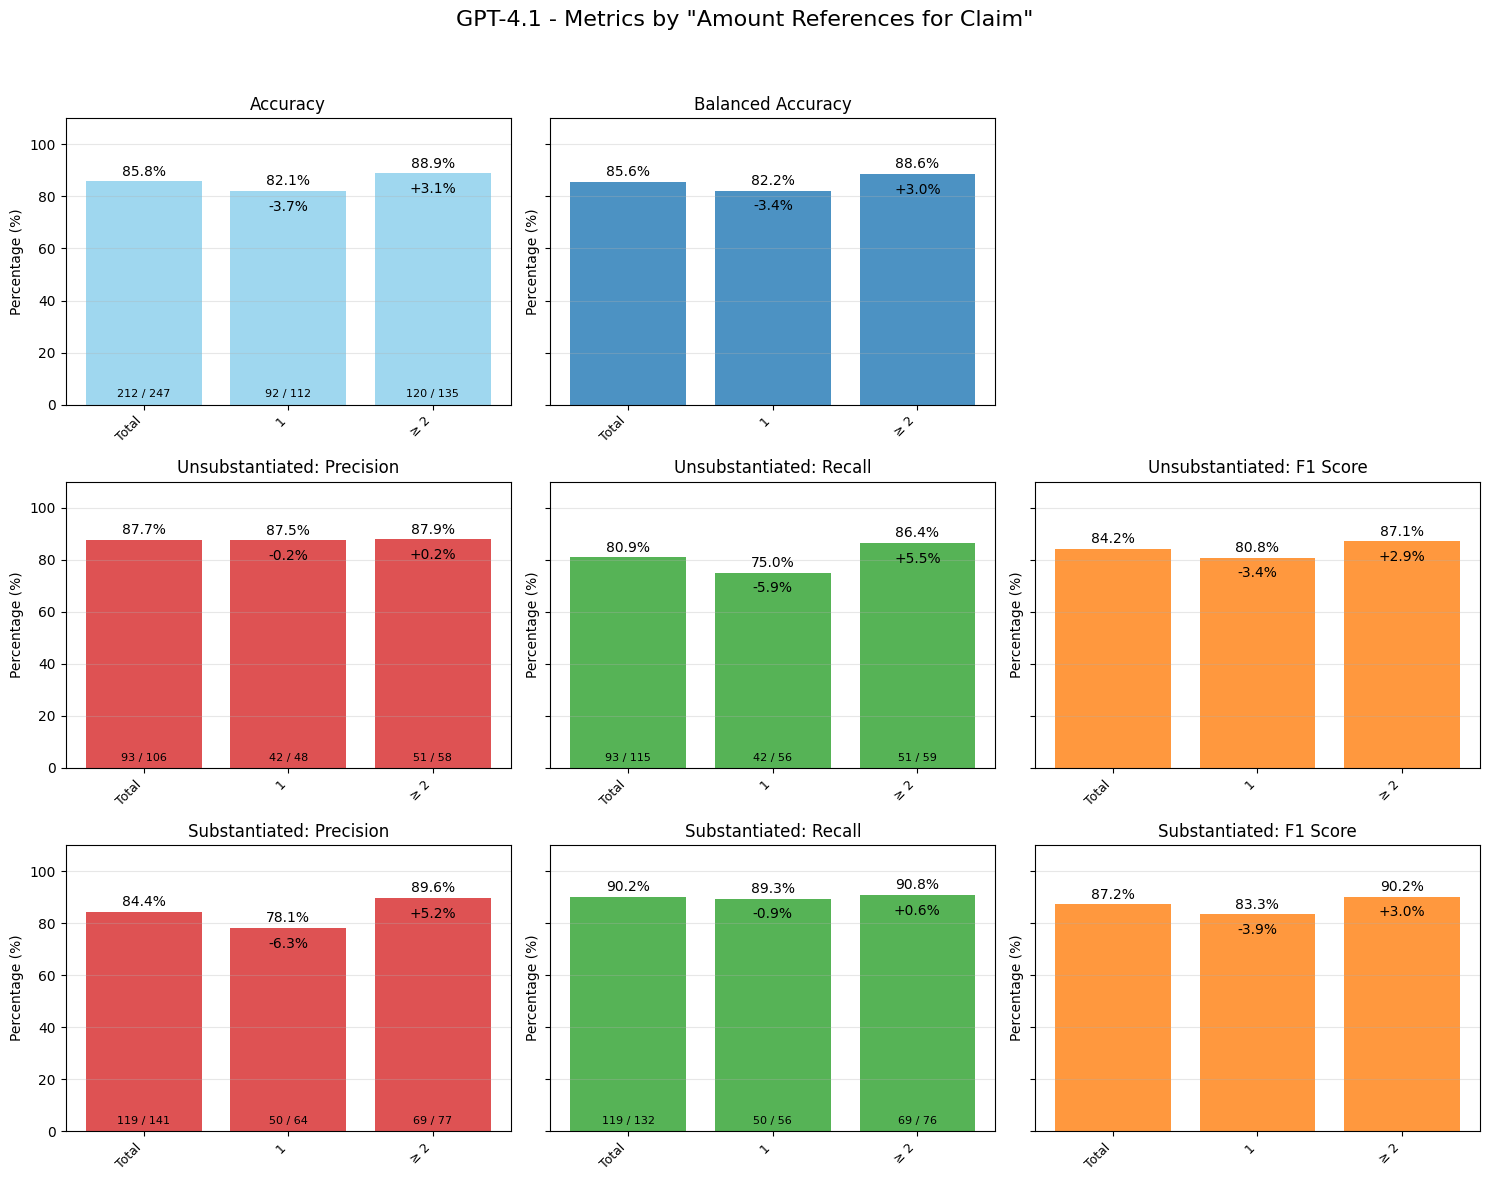

In [25]:
attribute = "Amount References for Claim"
results = attribute_predictions_per_model(model_dfs, attribute, group_numbers_from=2)
results_per_attribute[attribute] = results[analyzed_model]
show_metrics_by_attribute_values(results, attribute, analyzed_model)

In [26]:
significance_tests_results[attribute] = significance_tests_for_attribute(analyzed_df, analyzed_model, attribute, group_numbers_from=2)

---- ## Significance tests results for GPT-4.1 on attribute 'Amount References for Claim': ## ----
Fisher's exact test results (comparison over all attribute values):


,Total Odds Ratio,Total P-value,Unsubstantiated Odds Ratio,Unsubstantiated P-value,Substantiated Odds Ratio,Substantiated P-value
0,0.5750,0.1453,0.4706,0.1558,0.8454,0.7764


Time taken for overall Fisher's exact test: 0.02 seconds

Permutation test results (comparison per metric over 1000 permutations):


,Total Var Diff,Total P-value,Unsubstantiated Var Diff,Unsubstantiated P-value,Substantiated Var Diff,Substantiated P-value
Metric,,,,,,
Balanced Accuracy,0.000500,0.1720,N/A,N/A,N/A,N/A
Accuracy,0.000700,0.1350,N/A,N/A,N/A,N/A
Precision,N/A,N/A,-0.001000,0.9650,0.002300,0.0760
Recall,N/A,N/A,0.001700,0.1460,-0.000600,0.7720
F1 Score,N/A,N/A,0.000200,0.2410,0.000700,0.1150


Time taken for permutation test: 10.21 seconds






### Claim Sentence Structure

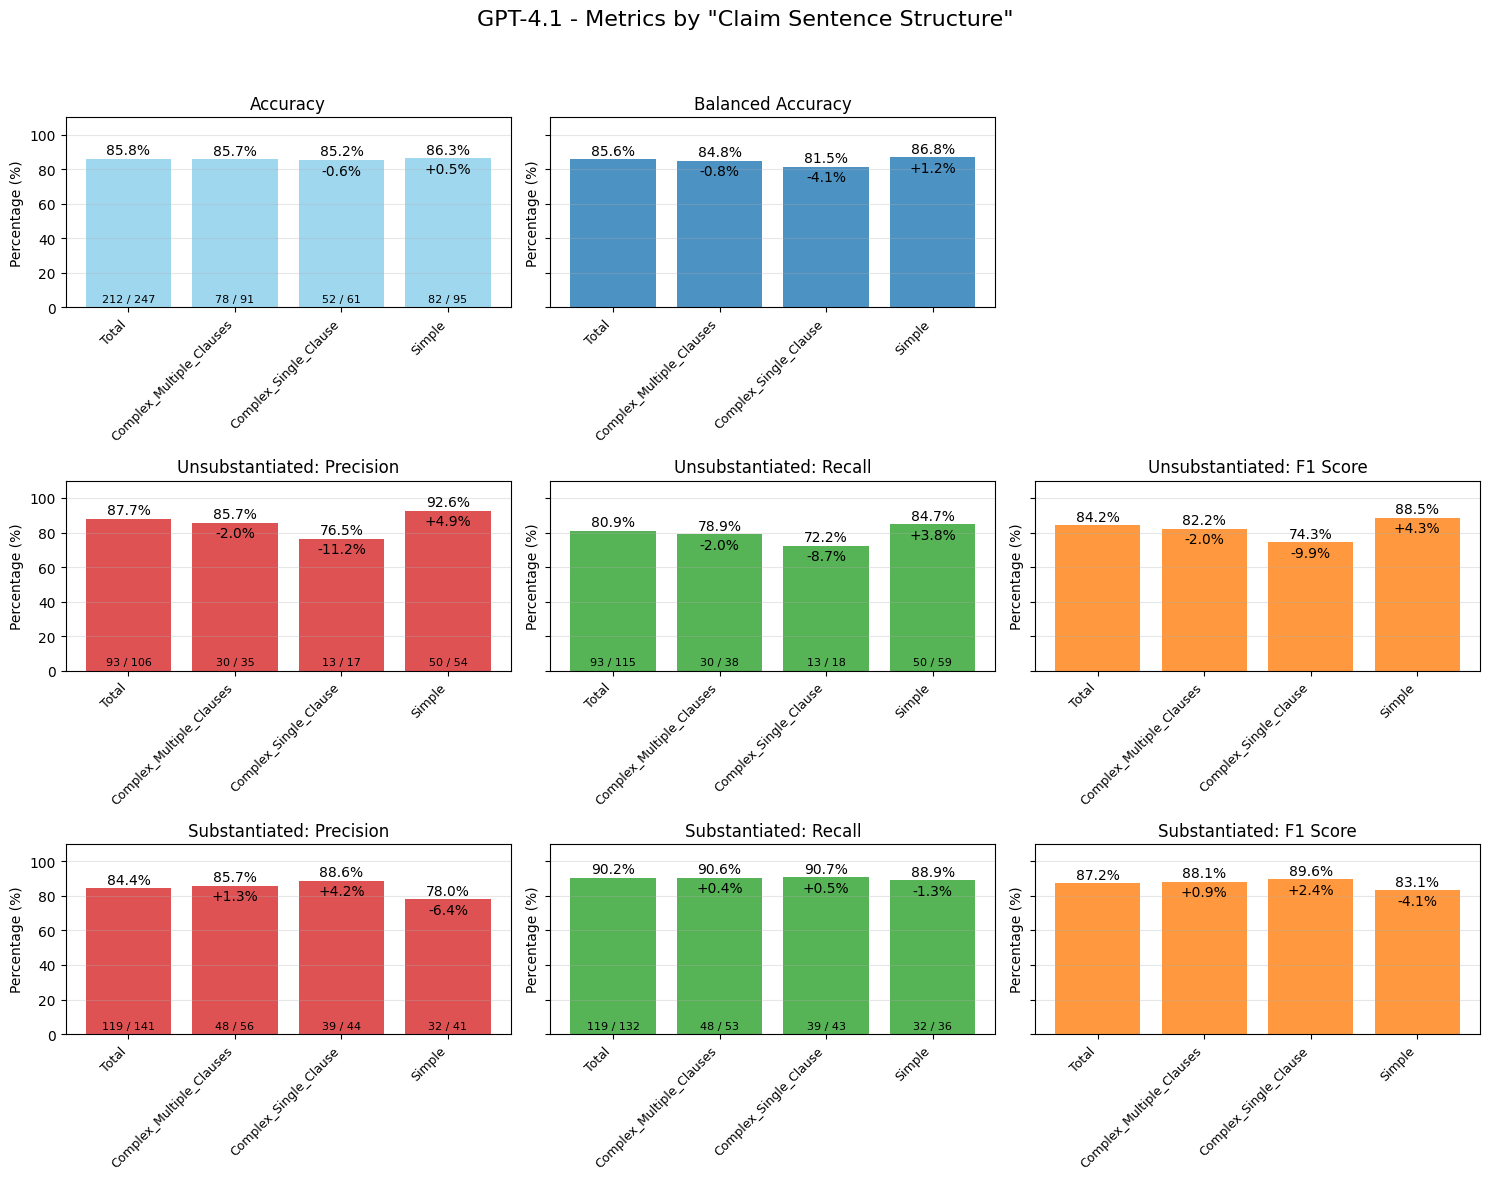

In [27]:
attribute = "Claim Sentence Structure"
results = attribute_predictions_per_model(model_dfs, attribute)
results_per_attribute[attribute] = results[analyzed_model]
show_metrics_by_attribute_values(results, attribute, analyzed_model)

In [28]:
significance_tests_results[attribute] = significance_tests_for_attribute(analyzed_df, analyzed_model, attribute)

---- ## Significance tests results for GPT-4.1 on attribute 'Claim Sentence Structure': ## ----
Fisher's exact test results (comparison over all attribute values):


,Total Statistic,Total P-value,Unsubstantiated Statistic,Unsubstantiated P-value,Substantiated Statistic,Substantiated P-value
0,0.0271,1.0000,0.0234,0.4246,0.0648,1.0000


Time taken for overall Fisher's exact test: 0.03 seconds

Permutation test results (comparison per metric over 1000 permutations):


,Total Var Diff,Total P-value,Unsubstantiated Var Diff,Unsubstantiated P-value,Substantiated Var Diff,Substantiated P-value
Metric,,,,,,
Balanced Accuracy,-0.000600,0.6350,N/A,N/A,N/A,N/A
Accuracy,-0.001100,0.9870,N/A,N/A,N/A,N/A
Precision,N/A,N/A,0.002100,0.1320,0.000000,0.3640
Recall,N/A,N/A,-0.000400,0.4350,-0.001300,0.9670
F1 Score,N/A,N/A,0.001800,0.1100,-0.000200,0.4470


Time taken for permutation test: 10.61 seconds






### Amount of Claims to Substantiate

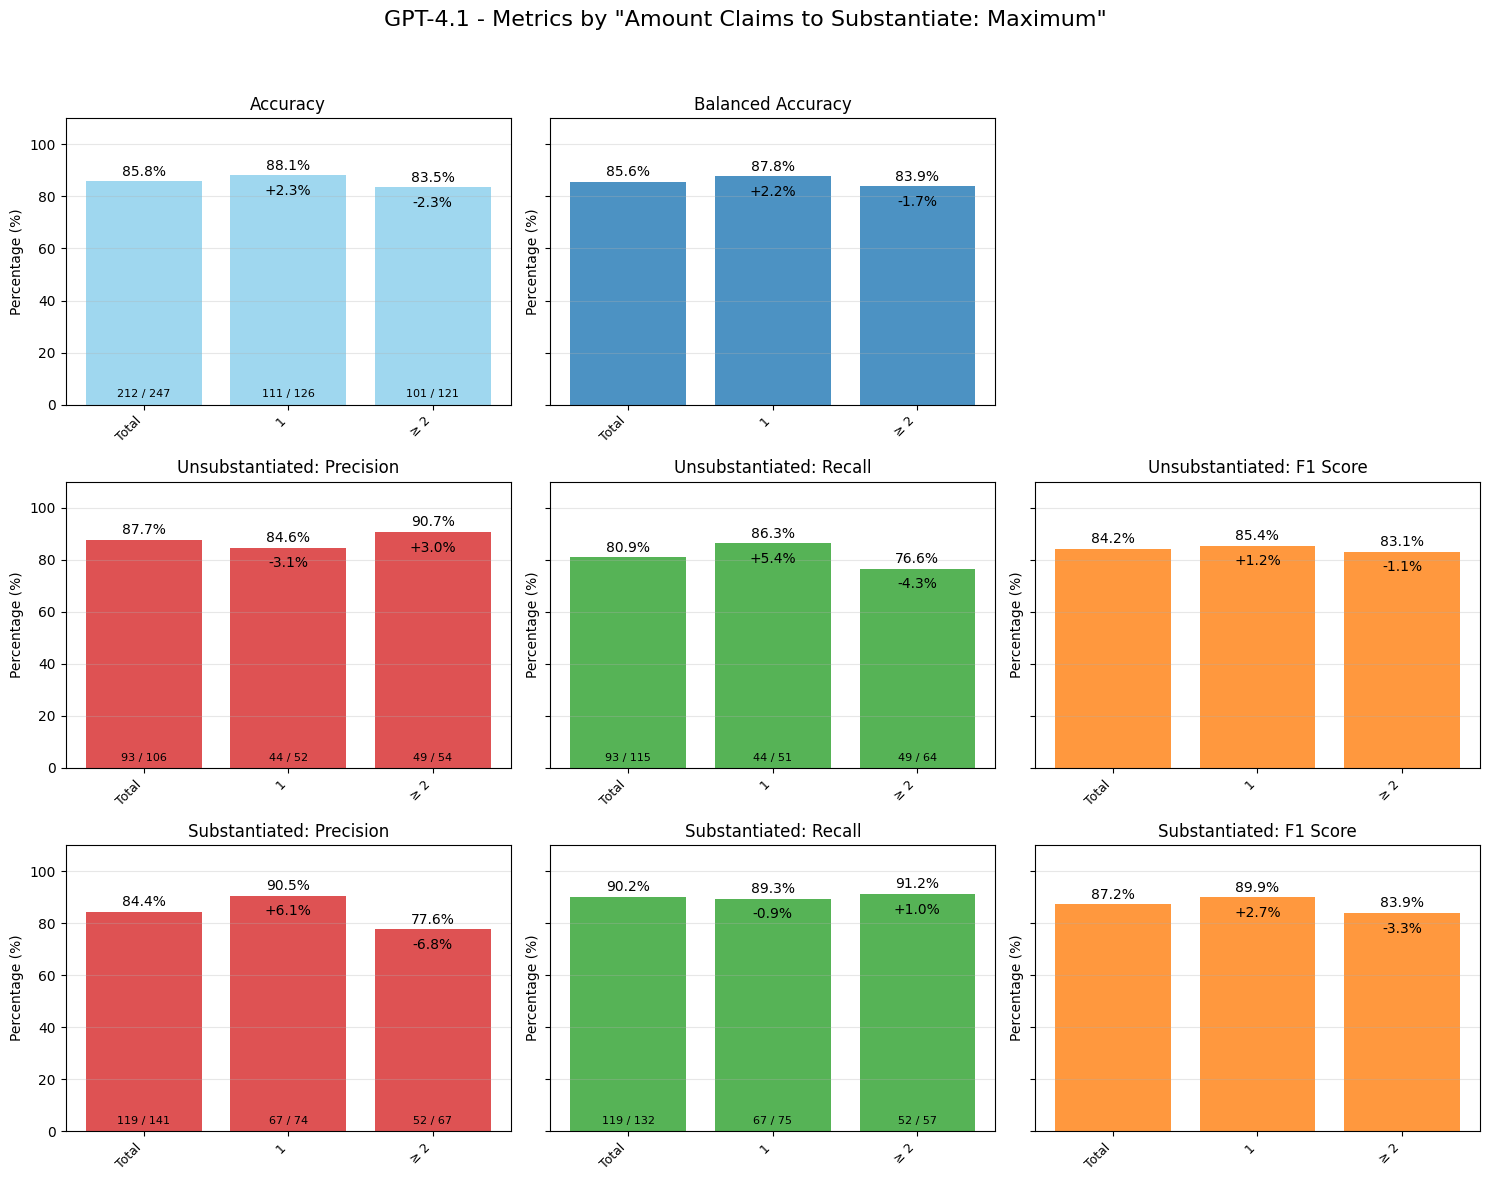

In [29]:
attribute = "Amount Claims to Substantiate: Maximum"
results = attribute_predictions_per_model(model_dfs, attribute, group_numbers_from=2)
results_per_attribute[attribute] = results[analyzed_model]
show_metrics_by_attribute_values(results, attribute, analyzed_model)

In [30]:
significance_tests_results[attribute] = significance_tests_for_attribute(analyzed_df, analyzed_model, attribute, group_numbers_from=2)

---- ## Significance tests results for GPT-4.1 on attribute 'Amount Claims to Substantiate: Maximum': ## ----
Fisher's exact test results (comparison over all attribute values):


,Total Odds Ratio,Total P-value,Unsubstantiated Odds Ratio,Unsubstantiated P-value,Substantiated Odds Ratio,Substantiated P-value
0,1.4653,0.3623,1.9242,0.2361,0.8053,0.7764


Time taken for overall Fisher's exact test: 0.02 seconds

Permutation test results (comparison per metric over 1000 permutations):


,Total Var Diff,Total P-value,Unsubstantiated Var Diff,Unsubstantiated P-value,Substantiated Var Diff,Substantiated P-value
Metric,,,,,,
Balanced Accuracy,-0.000200,0.4180,N/A,N/A,N/A,N/A
Accuracy,0.000000,0.3820,N/A,N/A,N/A,N/A
Precision,N/A,N/A,-0.000100,0.3440,0.003200,0.0470
Recall,N/A,N/A,0.000900,0.2240,-0.000600,0.7160
F1 Score,N/A,N/A,-0.000700,0.6730,0.000400,0.1790


Time taken for permutation test: 10.17 seconds






### Saving Results per Attribute

In [31]:
with open("../data/results_per_attribute.json", "w") as json_file:
    json.dump(results_per_attribute, json_file, indent=2)

In [32]:
with open("../data/results_per_attribute.json", "r") as json_file:
    results_per_attribute = json.load(json_file)

### Overall Plot of Metric Differences

In [33]:
attribute_names = {
    'Amount Citations in Sentence': 'Amount of Citations in Statement',
    'Amount References for Claim': 'Amount of References for Main Citation',
    'Amount Claims to Substantiate: Maximum': 'Amount of Claims to Substantiate (Maximum)',
    'Claim Sentence Structure': 'Citation Sentence Structure',
    'Claim Contains Number or Formula': 'Claim Contains Number or Formula',
    'Reference Only': 'Simple Topical Reference'
}

attribute_value_orders = {
    'Claim Sentence Structure': {
        'Simple': 'Simple', 
        'Complex_Single_Clause': 'Complex_\nSingle_\nClause', 
        'Complex_Multiple_Clauses': 'Complex_\nMultiple_\nClauses'
    },
    'Claim Contains Number or Formula': ['No', 'Number', 'Formula']
}

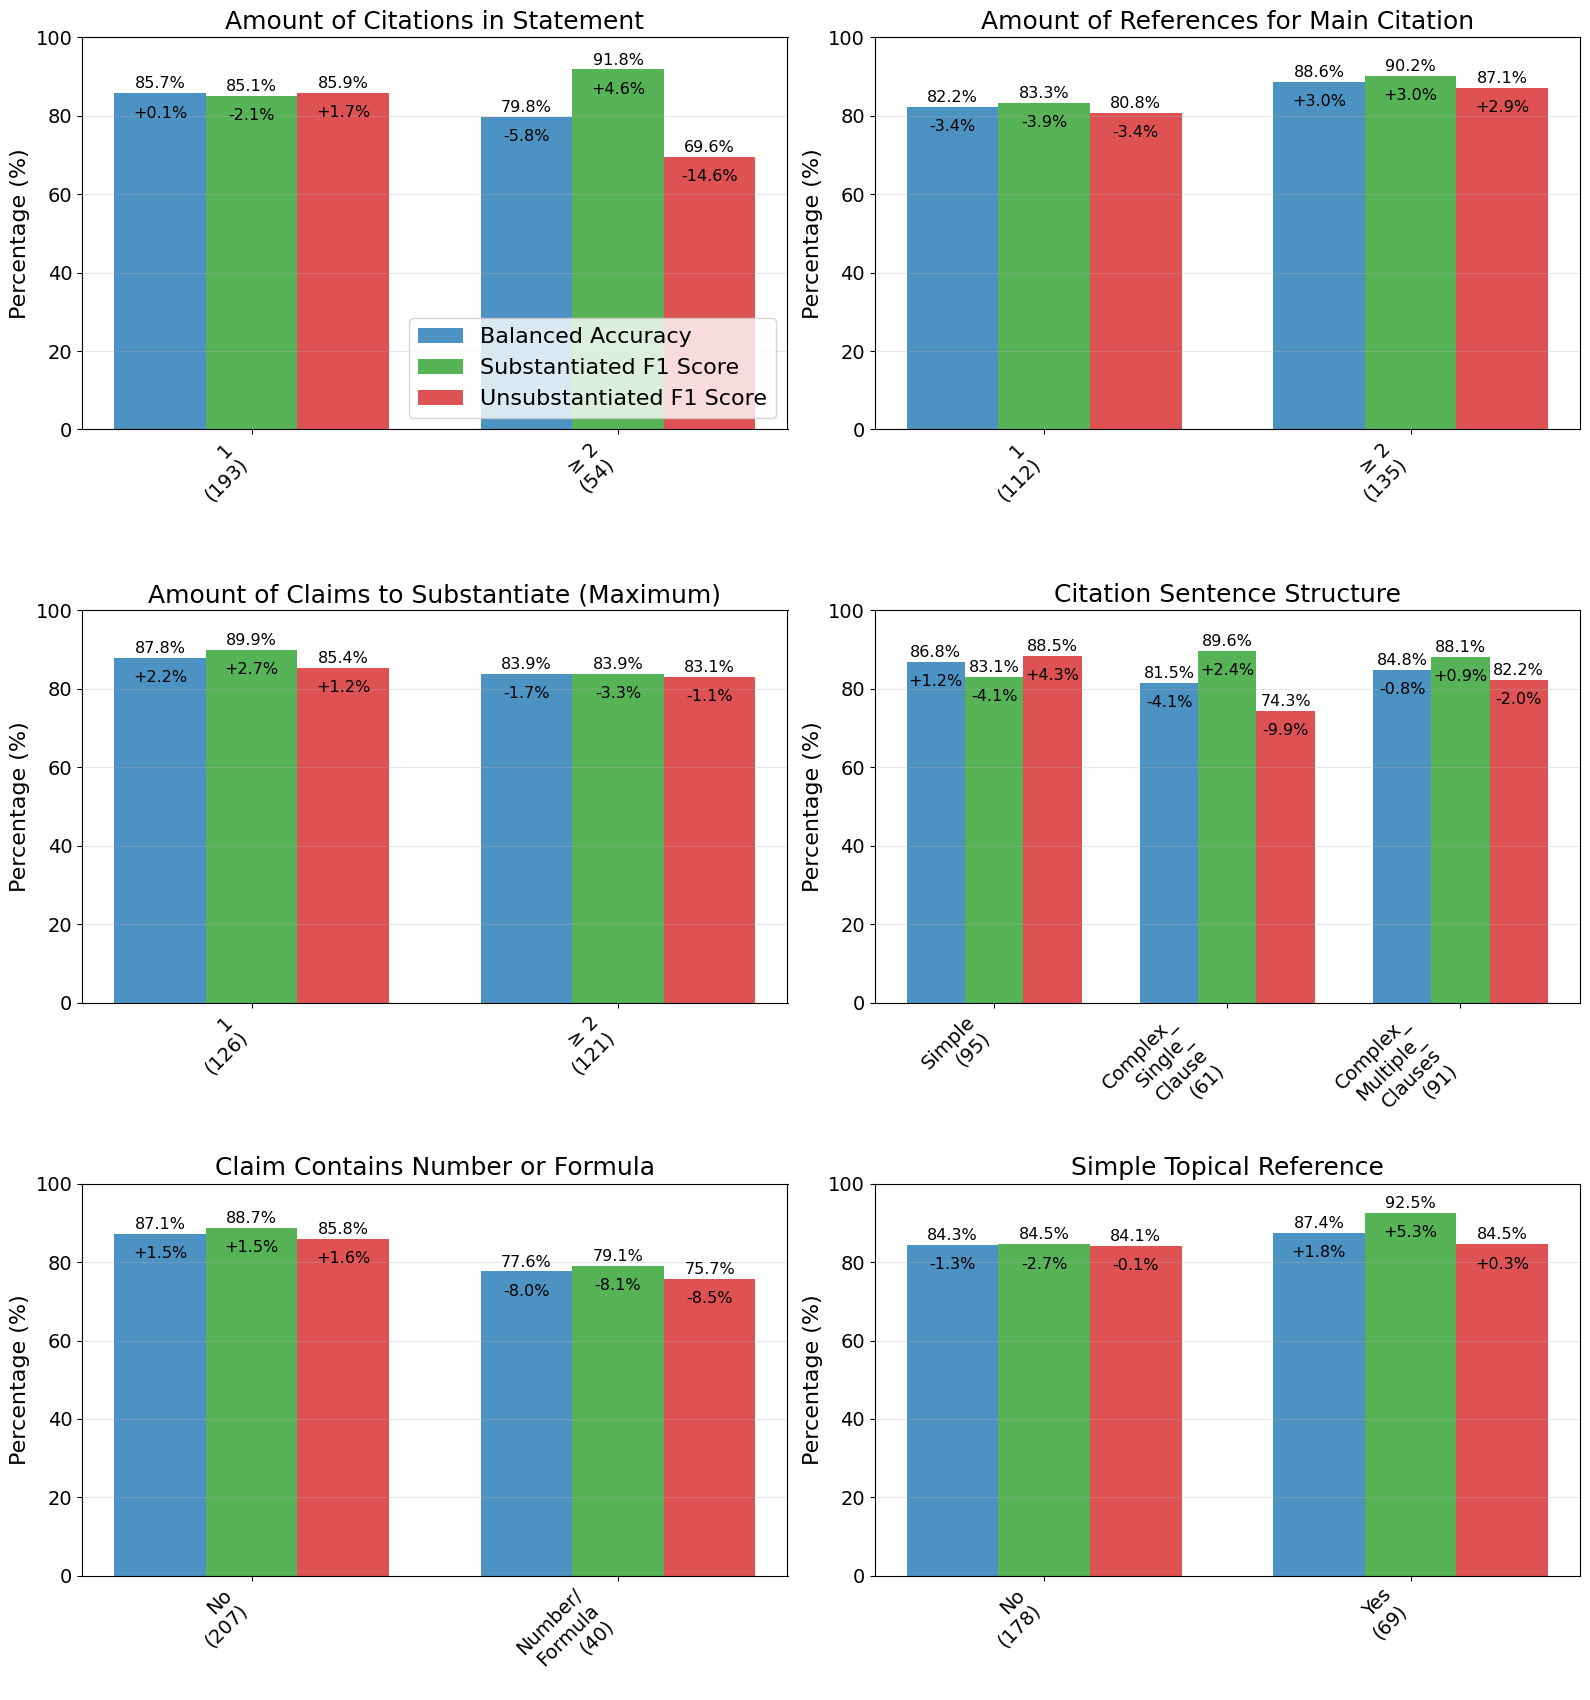


Total Metrics:
--------------------------------------------------
Balanced Accuracy: 85.6%
Substantiated F1: 87.2%
Unsubstantiated F1: 84.2%


In [34]:
show_metrics_by_annotation_attributes(results_per_attribute, "performance_by_attribute_values", attribute_names=attribute_names, attribute_value_orders=attribute_value_orders, show_totals=False)

## Overall Evaluation of Significance Test Results

In [34]:
significance_results = extract_p_values(significance_tests_results)

In [35]:
attributes = list(significance_results.keys())
attributes

['Reference Only',
 'Claim Contains Number or Formula',
 'Amount Citations in Sentence',
 'Amount References for Claim',
 'Claim Sentence Structure',
 'Amount Claims to Substantiate: Maximum']

In [36]:
p_values_by_test = reorganize_p_values_by_test_type(significance_results)

### Multiple Testing Adjustment using Holm Procedure

#### Overall Fisher's Exact Test Results

In [37]:
def get_value_by_attribute(data, attribute_name):
    for attr, value in data:
        if attr == attribute_name:
            return value
    return None  # or raise KeyError if not found

In [38]:
overall_fishers_results = p_values_by_test['Fisher Exact Overall']
overall_fishers_results
adjusted_fishers_results = {}

for label_set in overall_fishers_results:
    rejected_null_hypotheses, accepted_null_hypotheses = holm_p_value_correction(overall_fishers_results[label_set])
    for r in rejected_null_hypotheses:
        attribute, value = r
        adjusted_fishers_results.setdefault(label_set, {})[attribute] = {
            'original': get_value_by_attribute(overall_fishers_results[label_set], attribute),
            'adjusted': value
        }
    for a in accepted_null_hypotheses:
        attribute, value = a
        adjusted_fishers_results.setdefault(label_set, {})[attribute] = {
            'original': get_value_by_attribute(overall_fishers_results[label_set], attribute),
            'adjusted': value
        }
    print(f"---- Label set: {label_set} ----")
    print_holm_correction_results_as_table(rejected_null_hypotheses, accepted_null_hypotheses, p_values_by_test['Fisher Exact Overall'], label_set)

---- Label set: Total ----


,Test Name,Original p-value,Adjusted p-value,Significant
0,Amount References for Claim,0.1453,0.8718,No
1,Claim Contains Number or Formula,0.1503,0.7515,No
2,Reference Only,0.3129,1.0000,No
3,Amount Claims to Substantiate: Maximum,0.3623,1.0000,No
4,Amount Citations in Sentence,1.0000,1.0000,No
5,Claim Sentence Structure,1.0000,1.0000,No


---- Label set: Substantiated ----


,Test Name,Original p-value,Adjusted p-value,Significant
0,Claim Contains Number or Formula,0.0299,0.1794,No
1,Reference Only,0.2172,1.0000,No
2,Amount Citations in Sentence,0.5499,1.0000,No
3,Amount References for Claim,0.7764,1.0000,No
4,Amount Claims to Substantiate: Maximum,0.7764,1.0000,No
5,Claim Sentence Structure,1.0000,1.0000,No


---- Label set: Unsubstantiated ----


,Test Name,Original p-value,Adjusted p-value,Significant
0,Amount References for Claim,0.1558,0.9348,No
1,Amount Claims to Substantiate: Maximum,0.2361,1.0000,No
2,Amount Citations in Sentence,0.2396,0.9584,No
3,Claim Sentence Structure,0.4192,1.0000,No
4,Claim Contains Number or Formula,0.5585,1.0000,No
5,Reference Only,0.7769,0.7769,No


In [39]:
attribute_order = ['Amount Citations in Sentence',
                   'Amount References for Claim',
                   'Amount Claims to Substantiate: Maximum',
                   'Claim Sentence Structure',
                   'Claim Contains Number or Formula',
                   'Reference Only']

table = generate_p_value_results_table(adjusted_fishers_results, attribute_order)
display(table)

,Total Original,Total Adjusted,Substantiated Original,Substantiated Adjusted,Unsubstantiated Original,Unsubstantiated Adjusted
Amount Citations in Sentence,1.0000,1.0000,0.5499,1.0000,0.2396,0.9584
Amount References for Claim,0.1453,0.8718,0.7764,1.0000,0.1558,0.9348
Amount Claims to Substantiate: Maximum,0.3623,1.0000,0.7764,1.0000,0.2361,1.0000
Claim Sentence Structure,1.0000,1.0000,1.0000,1.0000,0.4192,1.0000
Claim Contains Number or Formula,0.1503,0.7515,0.0299,0.1794,0.5585,1.0000
Reference Only,0.3129,1.0000,0.2172,1.0000,0.7769,0.7769


#### Permutation Test Results

In [40]:
chi_squared_results = p_values_by_test['Chi-Squared']

for label_set in chi_squared_results:
    rejected_null_hypotheses, accepted_null_hypotheses = holm_p_value_correction(chi_squared_results[label_set])
    print(f"---- Label set: {label_set} ----")
    print_holm_correction_results_as_table(rejected_null_hypotheses, accepted_null_hypotheses, p_values_by_test['Chi-Squared'], label_set)

In [41]:
permutation_results = p_values_by_test['Permutation Test']
adjusted_permutation_results = {}

for label_set in permutation_results:
    for metric in permutation_results[label_set]:
        rejected_null_hypotheses, accepted_null_hypotheses = holm_p_value_correction(permutation_results[label_set][metric])
        for r in rejected_null_hypotheses:
            attribute, value = r
            adjusted_permutation_results.setdefault(metric, {}).setdefault(label_set, {})[attribute] = {
                'original': get_value_by_attribute(permutation_results[label_set][metric], attribute),
                'adjusted': value
            }
        for a in accepted_null_hypotheses:
            attribute, value = a
            adjusted_permutation_results.setdefault(metric, {}).setdefault(label_set, {})[attribute] = {
                'original': get_value_by_attribute(permutation_results[label_set][metric], attribute),
                'adjusted': value
            }

        print(f"---- Label set: {label_set}, Metric: {metric} ----")
        print_holm_correction_results_as_table(rejected_null_hypotheses, accepted_null_hypotheses, p_values_by_test['Permutation Test'][label_set], metric)

---- Label set: Total, Metric: Accuracy ----


,Test Name,Original p-value,Adjusted p-value,Significant
0,Amount References for Claim,0.1350,0.8100,No
1,Reference Only,0.3110,1.0000,No
2,Amount Claims to Substantiate: Maximum,0.3820,1.0000,No
3,Claim Contains Number or Formula,0.6540,1.0000,No
4,Amount Citations in Sentence,0.8020,1.0000,No
5,Claim Sentence Structure,0.9870,0.9870,No


---- Label set: Total, Metric: Balanced Accuracy ----


,Test Name,Original p-value,Adjusted p-value,Significant
0,Amount References for Claim,0.1720,1.0000,No
1,Amount Citations in Sentence,0.2660,1.0000,No
2,Amount Claims to Substantiate: Maximum,0.4180,1.0000,No
3,Reference Only,0.5390,1.0000,No
4,Claim Sentence Structure,0.6350,1.0000,No
5,Claim Contains Number or Formula,0.6510,0.6510,No


---- Label set: Substantiated, Metric: Precision ----


,Test Name,Original p-value,Adjusted p-value,Significant
0,Amount Claims to Substantiate: Maximum,0.0470,0.2820,No
1,Amount References for Claim,0.0760,0.3800,No
2,Amount Citations in Sentence,0.1910,0.7640,No
3,Reference Only,0.2540,0.7620,No
4,Claim Sentence Structure,0.3640,0.7280,No
5,Claim Contains Number or Formula,0.3800,0.3800,No


---- Label set: Substantiated, Metric: Recall ----


,Test Name,Original p-value,Adjusted p-value,Significant
0,Claim Contains Number or Formula,0.0630,0.3780,No
1,Reference Only,0.1670,0.8350,No
2,Amount Citations in Sentence,0.5690,1.0000,No
3,Amount Claims to Substantiate: Maximum,0.7160,1.0000,No
4,Amount References for Claim,0.7720,1.0000,No
5,Claim Sentence Structure,0.9670,0.9670,No


---- Label set: Substantiated, Metric: F1 Score ----


,Test Name,Original p-value,Adjusted p-value,Significant
0,Reference Only,0.1030,0.6180,No
1,Amount References for Claim,0.1150,0.5750,No
2,Amount Claims to Substantiate: Maximum,0.1790,0.7160,No
3,Claim Contains Number or Formula,0.1850,0.5550,No
4,Amount Citations in Sentence,0.1950,0.3900,No
5,Claim Sentence Structure,0.4470,0.4470,No


---- Label set: Unsubstantiated, Metric: Precision ----


,Test Name,Original p-value,Adjusted p-value,Significant
0,Amount Citations in Sentence,0.0220,0.1320,No
1,Claim Sentence Structure,0.1320,0.6600,No
2,Amount Claims to Substantiate: Maximum,0.3440,1.0000,No
3,Claim Contains Number or Formula,0.4070,1.0000,No
4,Reference Only,0.6430,1.0000,No
5,Amount References for Claim,0.9650,0.9650,No


---- Label set: Unsubstantiated, Metric: Recall ----


,Test Name,Original p-value,Adjusted p-value,Significant
0,Amount Citations in Sentence,0.0620,0.3720,No
1,Amount References for Claim,0.1460,0.7300,No
2,Amount Claims to Substantiate: Maximum,0.2240,0.8960,No
3,Claim Contains Number or Formula,0.3200,0.9600,No
4,Claim Sentence Structure,0.4350,0.8700,No
5,Reference Only,0.8380,0.8380,No


---- Label set: Unsubstantiated, Metric: F1 Score ----


,Test Name,Original p-value,Adjusted p-value,Significant
0,Amount Citations in Sentence,0.0120,0.0720,No
1,Claim Sentence Structure,0.1100,0.5500,No
2,Amount References for Claim,0.2410,0.9640,No
3,Claim Contains Number or Formula,0.4990,1.0000,No
4,Amount Claims to Substantiate: Maximum,0.6730,1.0000,No
5,Reference Only,0.9540,0.9540,No


In [42]:
attribute_order = ['Amount Citations in Sentence',
                   'Amount References for Claim',
                   'Amount Claims to Substantiate: Maximum',
                   'Claim Sentence Structure',
                   'Claim Contains Number or Formula',
                   'Reference Only']

print("Balanced Accuracy")
table = generate_p_value_results_table(adjusted_permutation_results['Balanced Accuracy'], attribute_order)
display(table)

print("F1 Score")
table = generate_p_value_results_table(adjusted_permutation_results['F1 Score'], attribute_order)
display(table)

Balanced Accuracy


,Total Original,Total Adjusted
Amount Citations in Sentence,0.266,1.000
Amount References for Claim,0.172,1.000
Amount Claims to Substantiate: Maximum,0.418,1.000
Claim Sentence Structure,0.635,1.000
Claim Contains Number or Formula,0.651,0.651
Reference Only,0.539,1.000


F1 Score


,Substantiated Original,Substantiated Adjusted,Unsubstantiated Original,Unsubstantiated Adjusted
Amount Citations in Sentence,0.195,0.390,0.012,0.072
Amount References for Claim,0.115,0.575,0.241,0.964
Amount Claims to Substantiate: Maximum,0.179,0.716,0.673,1.000
Claim Sentence Structure,0.447,0.447,0.110,0.550
Claim Contains Number or Formula,0.185,0.555,0.499,1.000
Reference Only,0.103,0.618,0.954,0.954
